In [1]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


/home/mattmori/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-20 13:56:09.105424: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-20 13:56:09.180931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 13:56:09.180979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 13:56:09.183161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

modules loaded


In [2]:
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import itertools
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import zipfile
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Define Data Path and Data Set Name

In [3]:
# REPLACE NAMES
train_data_dir = '/mnt/c/Users/mattm/OneDrive/Documents/ecs111/ecs111_project_pet_emotions_repo/ecs111/pet_images/Master Folder/train'
valid_data_dir = '/mnt/c/Users/mattm/OneDrive/Documents/ecs111/ecs111_project_pet_emotions_repo/ecs111/pet_images/Master Folder/valid'
test_data_dir = '/mnt/c/Users/mattm/OneDrive/Documents/ecs111/ecs111_project_pet_emotions_repo/ecs111/pet_images/Master Folder/test'

data_dir = '/mnt/c/Users/mattm/OneDrive/Documents/ecs111/ecs111_project_pet_emotions_repo/ecs111/pet_images'


ds_name = 'Pets Facial Expression'


In [4]:
# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        if fold == 'Master Folder':
            continue
            
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [5]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)
df.head()


filepaths labels
0  /mnt/c/Users/mattm/OneDrive/Documents/ecs111/e...  Angry
1  /mnt/c/Users/mattm/OneDrive/Documents/ecs111/e...  Angry
2  /mnt/c/Users/mattm/OneDrive/Documents/ecs111/e...  Angry
3  /mnt/c/Users/mattm/OneDrive/Documents/ecs111/e...  Angry
4  /mnt/c/Users/mattm/OneDrive/Documents/ecs111/e...  Angry

In [6]:
print(df['labels'].value_counts())
counts = df['labels'].value_counts()

Other    253
Angry    250
happy    250
Sad      250
Name: labels, dtype: int64


In [7]:
def analyze_dataset(df, name='df'):
    num_images = df.shape[0]
    num_classes = len(df['labels'].unique())
    
    print(f"The {name} dataset has {num_images} images.")
    print(f"The {name} dataset has {num_classes} classes.")
    
    print(f"The {name} dataset has:")
    print("=" * 70)
    print()
    
    for label, group in df.groupby('labels'):
        num_class = len(group)
        print(f"Class '{label}' has {num_class} images")
        print('-' * 70)

# Example Usage
# Assuming df and ds_name are defined
analyze_dataset(df, ds_name)

The Pets Facial Expression dataset has 1003 images.
The Pets Facial Expression dataset has 4 classes.
The Pets Facial Expression dataset has:

Class 'Angry' has 250 images
----------------------------------------------------------------------
Class 'Other' has 253 images
----------------------------------------------------------------------
Class 'Sad' has 250 images
----------------------------------------------------------------------
Class 'happy' has 250 images
----------------------------------------------------------------------


Define Data Path and Data Set Name

In [8]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"The {name} dataset has no null values")
    
    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        

check_null_values(df, ds_name)

The Pets Facial Expression dataset has no null values


Spliting the dataframe into train, valid, and test

In [9]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)


In [10]:
analyze_dataset(train_df, "Training "+ds_name)
analyze_dataset(valid_df, "Validation "+ds_name)
analyze_dataset(test_df, "Testing "+ds_name)

The Training Pets Facial Expression dataset has 802 images.
The Training Pets Facial Expression dataset has 4 classes.
The Training Pets Facial Expression dataset has:

Class 'Angry' has 197 images
----------------------------------------------------------------------
Class 'Other' has 217 images
----------------------------------------------------------------------
Class 'Sad' has 193 images
----------------------------------------------------------------------
Class 'happy' has 195 images
----------------------------------------------------------------------
The Validation Pets Facial Expression dataset has 120 images.
The Validation Pets Facial Expression dataset has 4 classes.
The Validation Pets Facial Expression dataset has:

Class 'Angry' has 35 images
----------------------------------------------------------------------
Class 'Other' has 21 images
----------------------------------------------------------------------
Class 'Sad' has 33 images
----------------------------------

Create Image Data Generator

In [11]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 802 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.


Visualizing the Data Set

In [12]:
fig = go.Figure(go.Bar(
            x= counts.values,
            y=counts.index,
            orientation='h'))

fig.update_layout(title='Data Distribution in Bars',font_size=15,title_x=0.45)

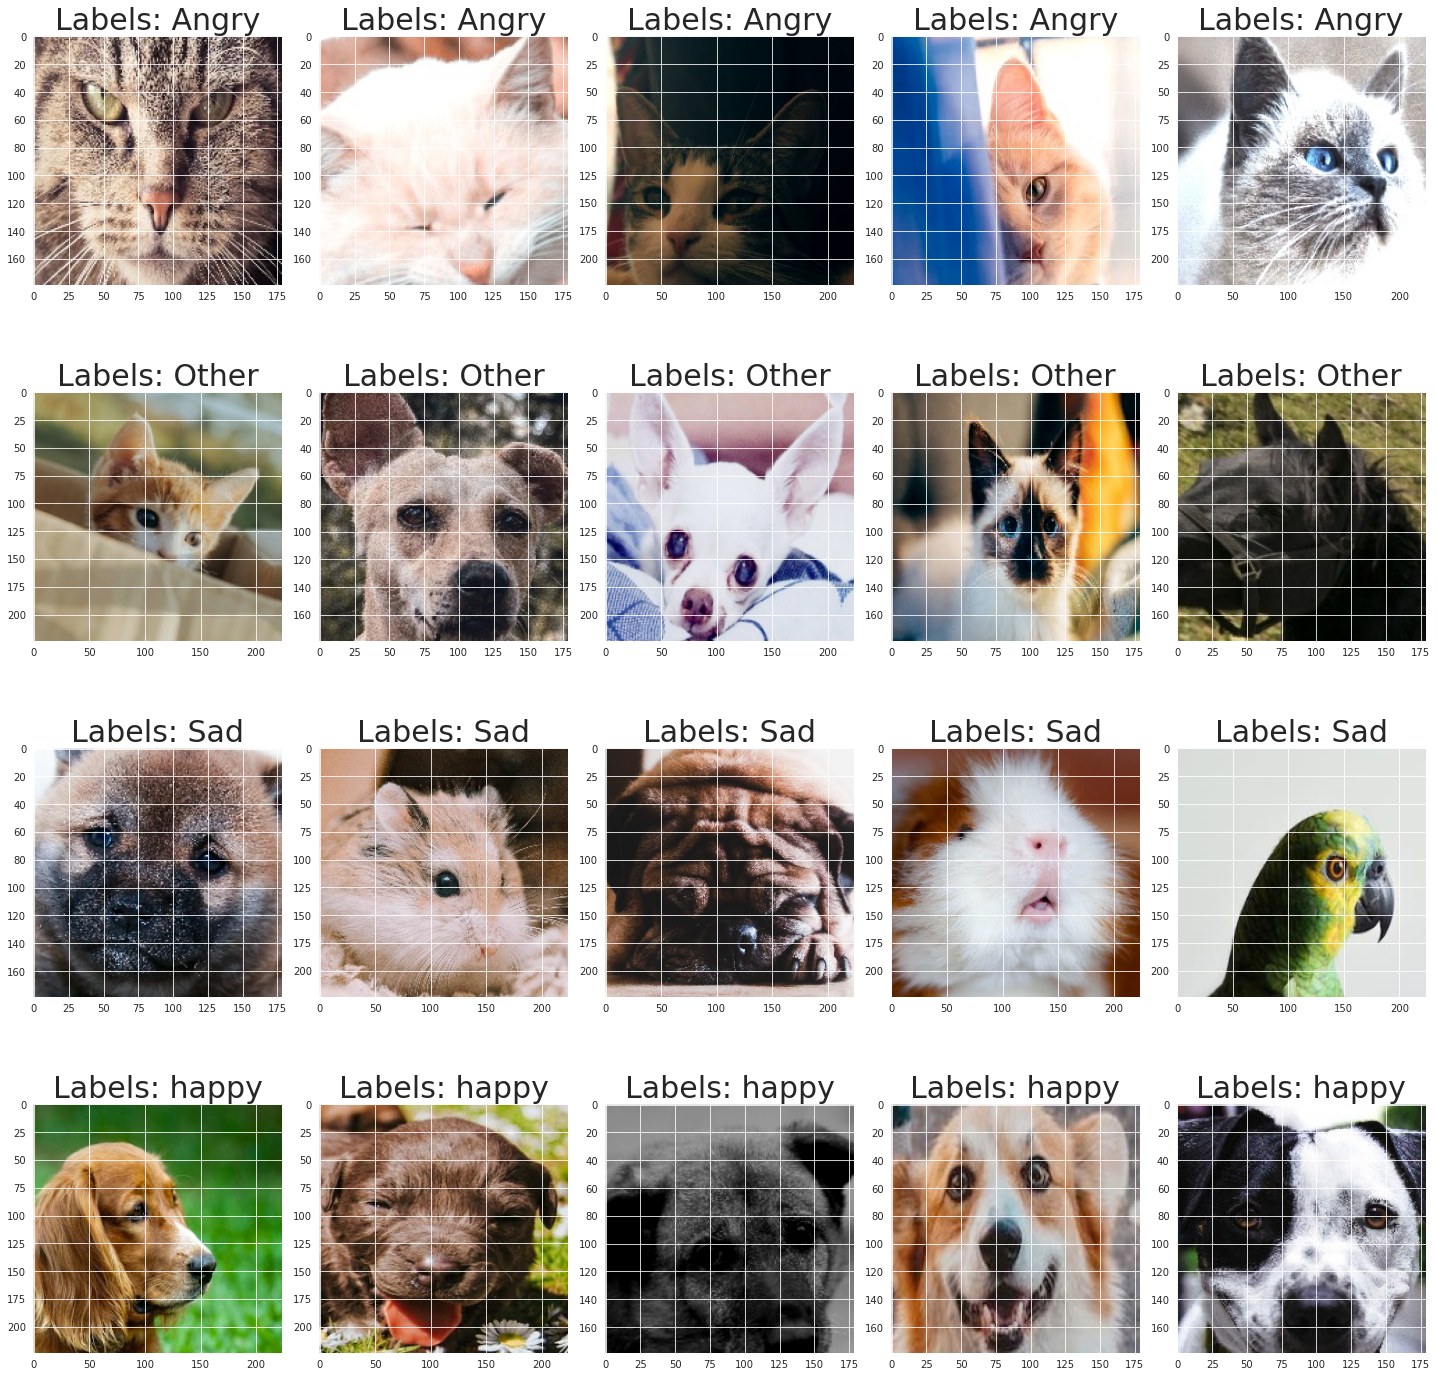

In [13]:
image_dir = "../working/train/"
grouped_data = df.groupby("labels")

num_images_per_category = 5

fig, axes = plt.subplots(len(grouped_data), num_images_per_category, figsize=(20, 20))

for i, (category, group) in enumerate(grouped_data):
  
    random_indices = random.sample(range(len(group)), num_images_per_category)

    for j, index in enumerate(random_indices):
        filename = group.iloc[index]["filepaths"]
        label = group.iloc[index]["labels"]
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)

        axes[i, j].imshow(image)
        axes[i, j].set_title("Labels: " + label, fontsize = 30)
        

plt.tight_layout()
plt.show()

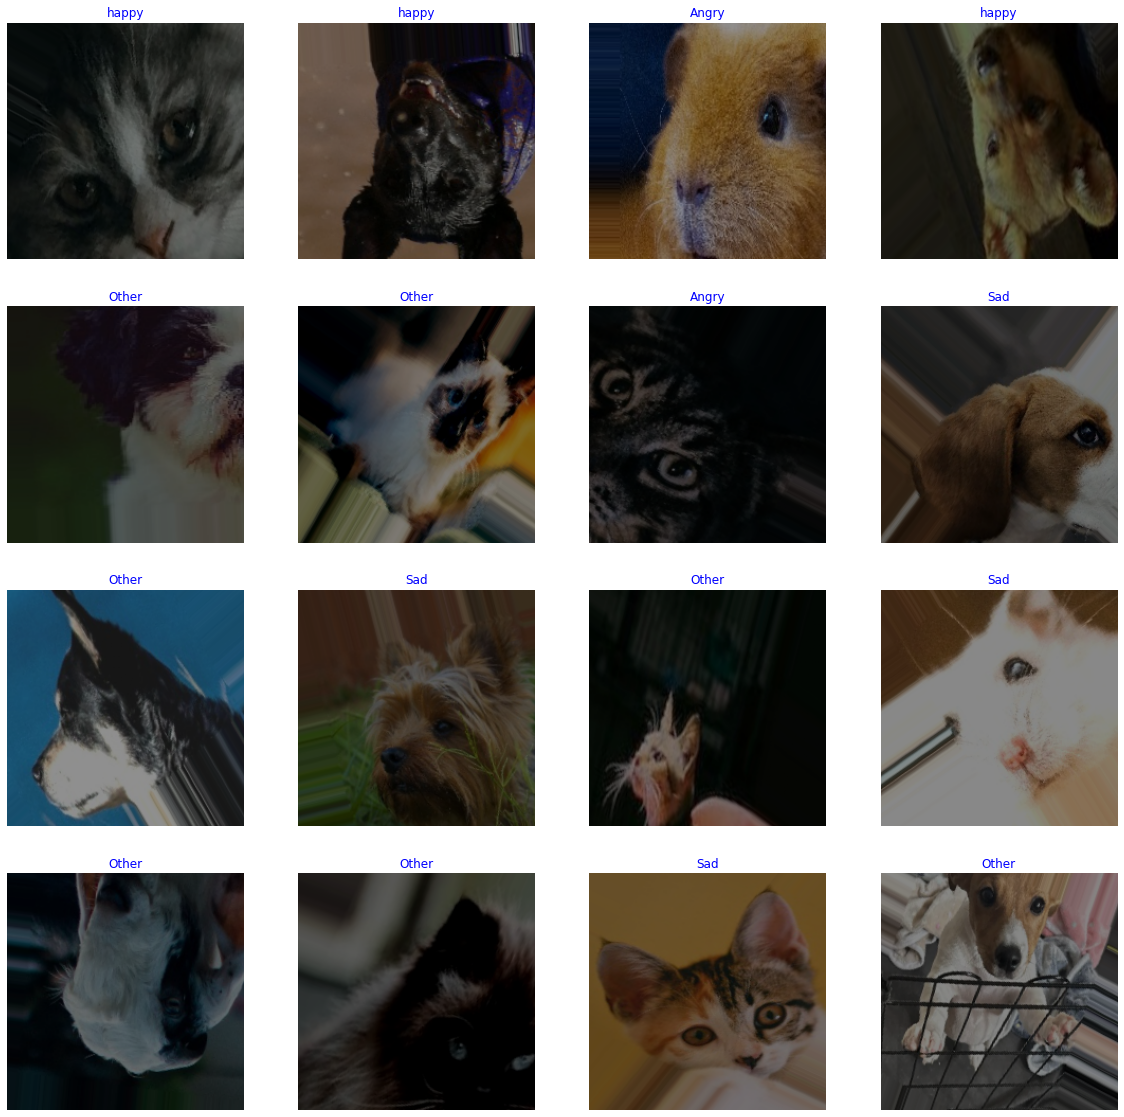

In [14]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()


Creating the Plot

In [15]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.summary()

2024-02-20 13:56:31.190040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:3b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 13:56:31.192214: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


115263384/115263384 [==============================] - 69s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

Compiling the Model

In [17]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Training the Model

In [19]:
batch_size = 16   # set batch size for training
history = model.fit(x=train_gen,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/10
51/51 [==============================] - 195s 4s/step - loss: 3.9327 - accuracy: 0.4451 - val_loss: 3.6697 - val_accuracy: 0.5750
Epoch 2/10
51/51 [==============================] - 130s 3s/step - loss: 3.7906 - accuracy: 0.4813 - val_loss: 3.5610 - val_accuracy: 0.5667
Epoch 3/10
51/51 [==============================] - 122s 2s/step - loss: 3.6957 - accuracy: 0.4975 - val_loss: 3.3938 - val_accuracy: 0.6250
Epoch 4/10
51/51 [==============================] - 112s 2s/step - loss: 3.5590 - accuracy: 0.5237 - val_loss: 3.4408 - val_accuracy: 0.6167
Epoch 5/10
51/51 [==============================] - 110s 2s/step - loss: 3.5114 - accuracy: 0.5237 - val_loss: 3.2968 - val_accuracy: 0.6833
Epoch 6/10
51/51 [==============================] - 121s 2s/step - loss: 3.3403 - accuracy: 0.5835 - val_loss: 3.1497 - val_accuracy: 0.7000
Epoch 7/10
51/51 [==============================] - 122s 2s/step - loss: 3.2411 - accuracy: 0.6010 - val_loss: 3.0902 - val_accuracy: 0.6917
Epoch 8/10
51

Evaluating the Model

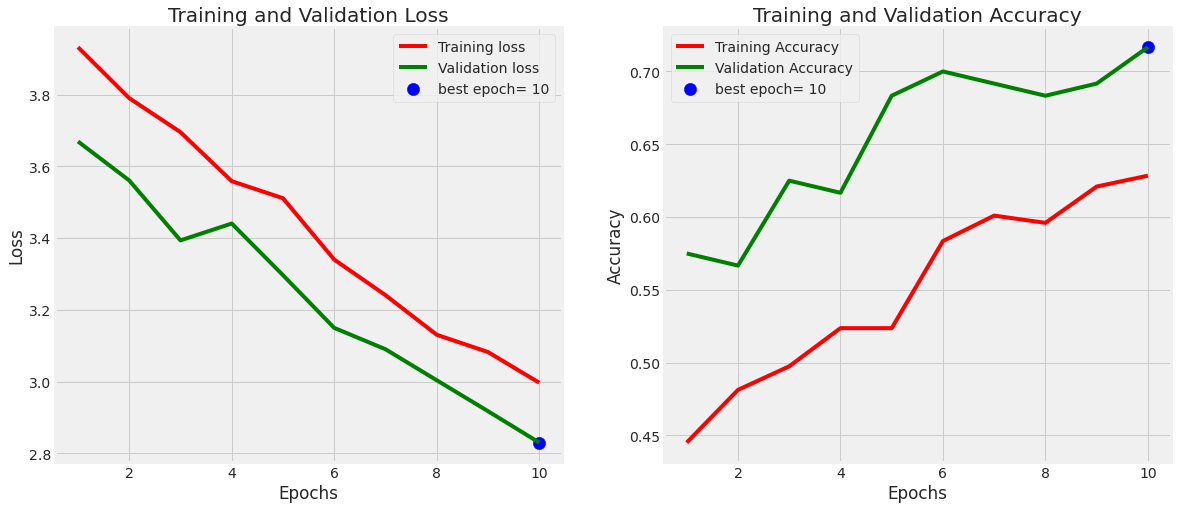

In [20]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Model Accuracy 

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

3/3 [==============================] - 9s 3s/step - loss: 2.8398 - accuracy: 0.7037
Train Loss:  2.71044659614563
Train Accuracy:  0.7083333134651184
--------------------
Test Loss:  2.8397560119628906
Test Accuracy:  0.7037037014961243


Getting the Prediction 

In [22]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)


In [ ]:
Confusion Matrix 

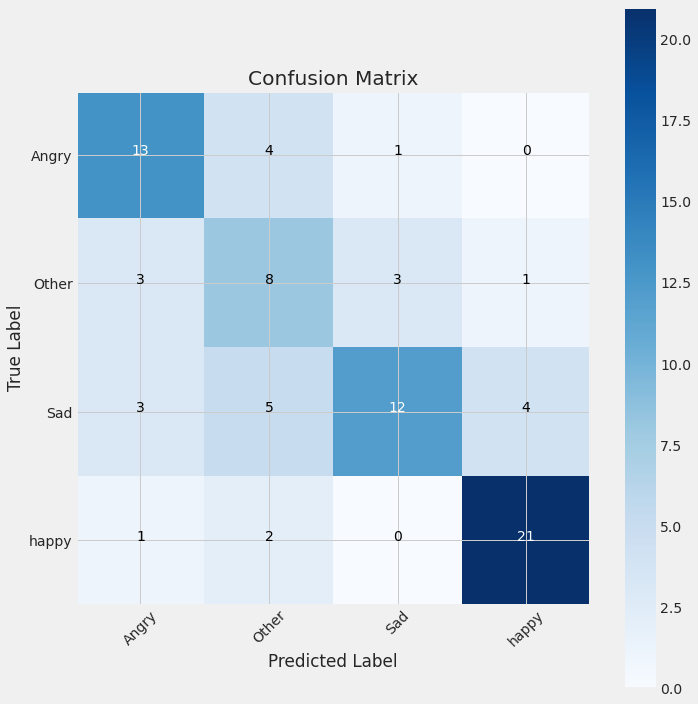

In [23]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [24]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       0.65      0.72      0.68        18
       Other       0.42      0.53      0.47        15
         Sad       0.75      0.50      0.60        24
       happy       0.81      0.88      0.84        24

    accuracy                           0.67        81
   macro avg       0.66      0.66      0.65        81
weighted avg       0.68      0.67      0.67        81



Loading the Model and Predicting Inputs!

1/1 [==============================] - 0s 342ms/step


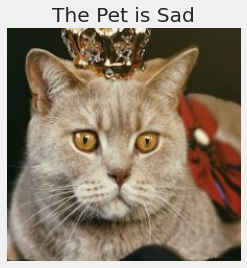

In [43]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    if predicted_class_label == 'Other':
        plt.title(f"The pet is normal")
    else:
        plt.title(f"The Pet is {predicted_class_label}")
    plt.show()
    
#model.load_weights('/kaggle/working/Pets_Facial_Expression_model.h5')

class_labels = ['Angry', 'Other', 'Sad', 'Happy']

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = "/mnt/c/Users/mattm/OneDrive/Documents/ecs111/ecs111_project_pet_emotions_repo/ecs111/pet_images/Sad/006.jpg"
predict_and_display(image_path_to_test, model)